# Fraud Detection Replica of IBM Watson Studio

In [44]:
!pip install imbalanced-learn
!pip install xgboost

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support, roc_curve, auc

from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

In [46]:
# Generate a synthetic dataset with 10,000 samples, 30 features, and a high imbalance

print("\n--- Generating Enhanced Synthetic Dataset ---")

# These will have a distribution similar to what make_classification typically produces
base_X, y = make_classification(n_samples=10000, n_features=28, n_informative=20,
                               n_redundant=0, n_repeated=0, n_classes=2,
                               n_clusters_per_class=1, weights=[0.995, 0.005],
                               flip_y=0, random_state=42)

# 2. Generate 'Time' feature with a distinct distribution (e.g., uniform over a period)
# In real fraud datasets, 'Time' is usually a large integer representing seconds from a starting point.
time_feature = np.random.uniform(low=0, high=172800, size=10000).reshape(-1, 1)
# Uniformly distributed over 48 hours (172800 seconds)

# 3. Generate 'Amount' feature with a distinct, often skewed distribution (e.g., log-normal)
# Transaction amounts are often positively skewed (many small transactions, few very large ones).
amount_feature = np.random.lognormal(mean=2.5, sigma=1.0, size=10000).reshape(-1, 1) * 100
# mean and sigma control the shape, multiplier scales it up to more typical amounts.

# 4. Combine all features into a single NumPy array
X_combined = np.hstack((base_X, time_feature, amount_feature))

# 5. Define all feature names, including the new 'Time' and 'Amount'
feature_names = [f'V{i}' for i in range(1, 29)] # V1 to V28
feature_names.append('Time')
feature_names.append('Amount')

# 6. Create DataFrame
df = pd.DataFrame(X_combined, columns=feature_names)
df['Class'] = y # 'Class' is our target variable (0: Not Fraud, 1: Fraud)

print("Enhanced synthetic dataset created successfully with distinct 'Time' and 'Amount' features!")
print("\nFirst 5 rows of the enhanced synthetic dataset:")
print(df.head())
print("\nDataset Info:")
df.info()

print("\n--- Performing Simple Feature Engineering ---")

# Example 1: Ratio of Amount to Time (or another feature)
# This could simulate transaction rate or density relative to value
# Adding a small constant to the denominator to avoid division by zero
df['Amount_per_Time'] = df['Amount'] / (df['Time'].abs() + 1e-6)
print("Added 'Amount_per_Time' feature.")

# Example 2: Interaction term between two 'V' features
# This can capture non-linear relationships that a linear model might miss
df['V1_x_V2'] = df['V1'] * df['V2']
print("Added 'V1_x_V2' interaction feature.")

# Example 3: Simple polynomial feature (e.g., square of Amount)
# Can capture non-linear impact of a single feature
df['Amount_squared'] = df['Amount']**2
print("Added 'Amount_squared' feature.")


# After adding these new features, your 'X' (features) needs to be redefined
# to include these new columns before scaling and splitting.
X = df.drop('Class', axis=1) # Update X to include all new features
y = df['Class']

print(f"\nUpdated X (features) shape after feature engineering: {X.shape}")
print("Ready for scaling and further processing!")


--- Generating Enhanced Synthetic Dataset ---
Enhanced synthetic dataset created successfully with distinct 'Time' and 'Amount' features!

First 5 rows of the enhanced synthetic dataset:
         V1        V2        V3        V4        V5        V6        V7  \
0 -1.011110  0.274938  0.289216 -1.403659  0.997677 -0.624382 -0.330901   
1  0.569315  5.894734  2.268613 -0.171947  4.133366 -0.622917 -0.568595   
2  2.119794  2.671887  2.470092 -0.733552  0.726212 -0.836551 -0.116287   
3  0.869556  1.423624 -0.062683  0.729186  3.580149 -1.841711 -0.742827   
4 -0.056620 -6.447756  0.725911 -1.670674  0.772656  2.111866 -0.725538   

         V8        V9       V10  ...       V22       V23       V24       V25  \
0 -0.551154  1.277579  1.508733  ...  1.167881 -2.385849  0.559402 -1.046483   
1 -0.010607  2.900669  4.354771  ...  1.457087  2.444111 -1.269530  0.841715   
2 -1.324732  3.913596  2.268611  ... -0.698117  2.256719 -0.936819 -0.800405   
3 -1.593546 -3.239682  3.958008  ...  0.4

In [47]:
X = df.drop('Class', axis=1) # Features (all columns except 'Class')
y = df['Class'] # Target variable ('Class' column)

print(f"\nShape of X (features): {X.shape}")
print(f"Shape of y (target): {y.shape}")


Shape of X (features): (10000, 33)
Shape of y (target): (10000,)



Features after StandardScaler transformation (first 5 rows):
         V1        V2        V3        V4        V5        V6        V7  \
0 -0.913180  0.491578  0.301837 -1.389348 -0.007482 -0.619391 -0.340687   
1 -0.190685  2.657225  2.301434 -0.155837  1.310428 -0.617917 -0.580005   
2  0.518120  1.415267  2.504969 -0.718261 -0.121577 -0.832952 -0.124606   
3 -0.053429  0.934236 -0.053653  0.746612  1.077915 -1.844704 -0.755428   
4 -0.476833 -2.099081  0.742988 -1.656752 -0.102057  2.134803 -0.738020   

         V8        V9       V10  ...       V24       V25       V26       V27  \
0  0.169704  0.104482  0.209500  ...  0.558484 -1.038210 -1.046751 -0.595021   
1  0.391603  0.687233  1.429081  ... -1.252850  0.843734 -0.139461 -0.069136   
2 -0.147855  1.050912  0.535122  ... -0.923340 -0.792948  0.088912 -0.820194   
3 -0.258205 -1.517386  1.259061  ...  0.640618  0.786462 -0.180759 -0.825108   
4  1.066422 -1.086979  0.142098  ...  0.350799  0.015726  0.832200  1.274999   

      

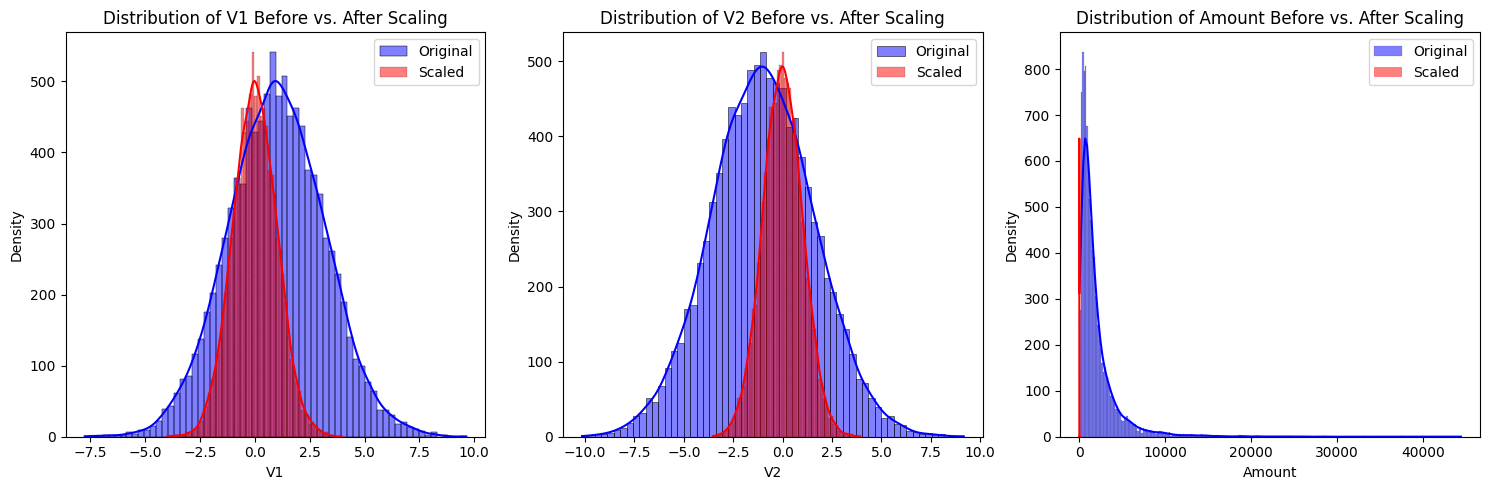

Notice how StandardScaler centers the data around 0 and normalizes its spread.


In [48]:
# Scaling
# Since the make_classification function generates features that might not be on a uniform scale, scaling is important
# Apply StandardScaler to all features (since make_classification generates them similarly)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("\nFeatures after StandardScaler transformation (first 5 rows):")
print(X_scaled_df.head())

# --- NEW VISUALIZATION: Feature Distribution Before vs. After Scaling ---
print("\nVisualizing Feature Distributions Before and After Scaling:")

# Choose a few features to visualize. 'V1' and 'Amount' are good examples if you had real data.
# For synthetic data, just pick a few like 'V1', 'V2', 'Amount'.
features_to_plot = ['V1', 'V2', 'Amount'] # Adjust these based on your feature_names list

plt.figure(figsize=(15, 5))

for i, feature in enumerate(features_to_plot):
    plt.subplot(1, len(features_to_plot), i + 1)
    sns.histplot(X[feature], kde=True, color='blue', label='Original')
    sns.histplot(X_scaled_df[feature], kde=True, color='red', label='Scaled', linestyle='--')
    plt.title(f'Distribution of {feature} Before vs. After Scaling')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()

print("Notice how StandardScaler centers the data around 0 and normalizes its spread.")


Training set shape: X_train (8000, 33), y_train (8000,)
Testing set shape: X_test (2000, 33), y_test (2000,)

Class distribution in training set:
Class
0    0.995
1    0.005
Name: proportion, dtype: float64

Class distribution in testing set:
Class
0    0.995
1    0.005
Name: proportion, dtype: float64

Visualizing Class Distribution Across Original, Training, and Testing Sets:


<Figure size 1000x600 with 0 Axes>

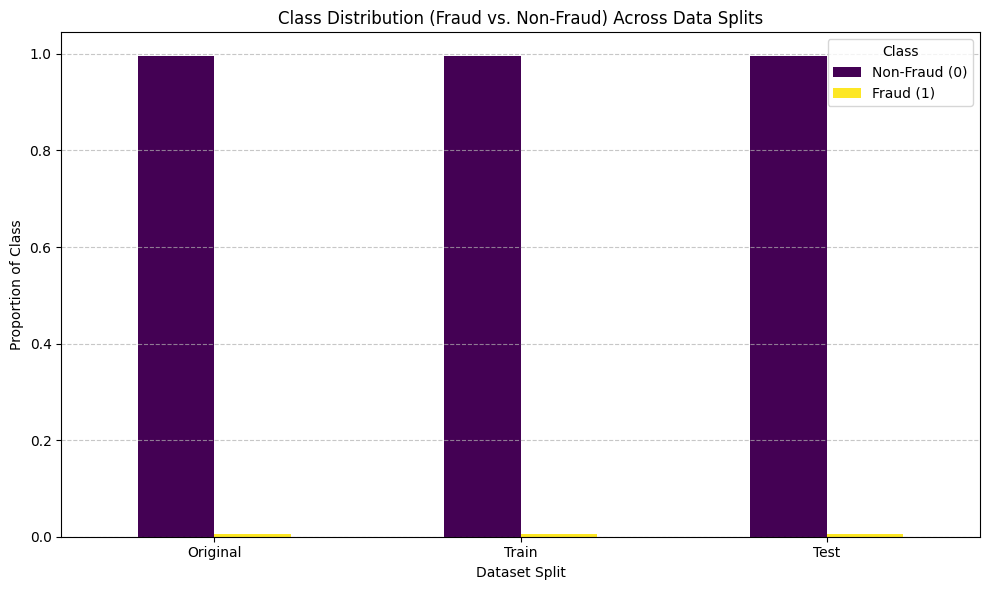

This plot confirms that the `stratify=y` parameter successfully maintained the original class proportions in both the training and testing sets.
Class
0    0.995
1    0.005
Name: proportion, dtype: float64


In [49]:
# Split Data into Training and Testing Sets

X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set shape: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Testing set shape: X_test {X_test.shape}, y_test {y_test.shape}")

print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in testing set:")
print(y_test.value_counts(normalize=True))

# Class Distribution Across Splits
print("\nVisualizing Class Distribution Across Original, Training, and Testing Sets:")

# Combine class distributions into a single DataFrame for easy plotting
original_dist = df['Class'].value_counts(normalize=True).rename('Original').to_frame()
train_dist = y_train.value_counts(normalize=True).rename('Train').to_frame()
test_dist = y_test.value_counts(normalize=True).rename('Test').to_frame()

combined_dist = pd.concat([original_dist, train_dist, test_dist], axis=1)

# Plotting
plt.figure(figsize=(10, 6))
combined_dist.T.plot(kind='bar', stacked=False, figsize=(10, 6), cmap='viridis') # Transpose for categories on X-axis
plt.title('Class Distribution (Fraud vs. Non-Fraud) Across Data Splits')
plt.xlabel('Dataset Split')
plt.ylabel('Proportion of Class')
plt.xticks(rotation=0)
plt.legend(title='Class', labels=['Non-Fraud (0)', 'Fraud (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("This plot confirms that the `stratify=y` parameter successfully maintained the original class proportions in both the training and testing sets.")
print(y_test.value_counts(normalize=True))


Applying SMOTE to balance the training data...
Original training set shape: (8000, 33)
Resampled training set shape: (15920, 33)

Class distribution in resampled training set:
Class
0    7960
1    7960
Name: count, dtype: int64
Training data is now balanced!

Visualizing Class Distribution Before and After SMOTE Resampling:


<Figure size 1000x600 with 0 Axes>

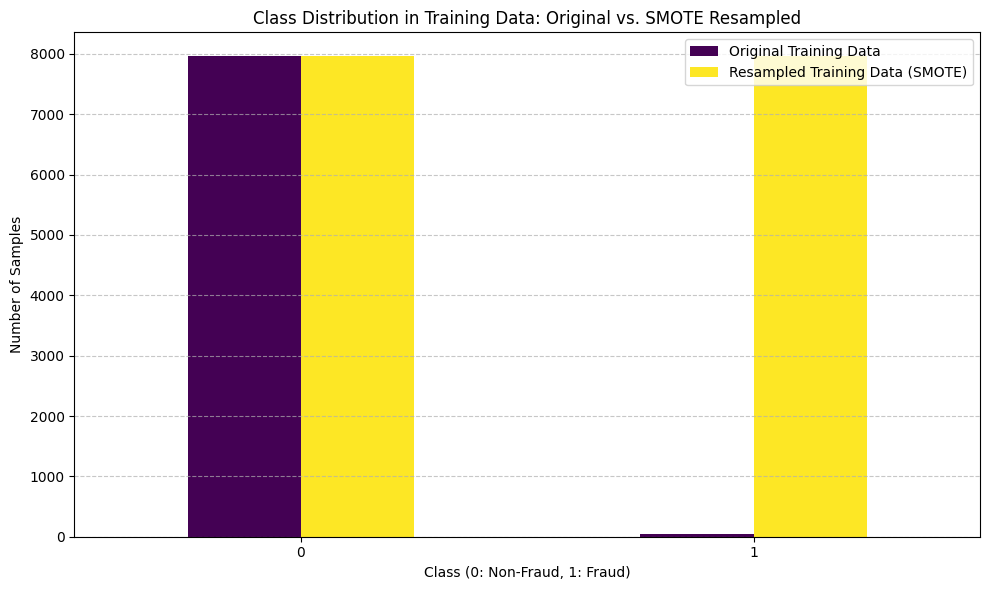

This plot shows how SMOTE has increased the number of minority class samples (Fraud) to match the majority class in the training data.


In [50]:
# Handle Imbalanced Data
# Apply SMOTE to the training data

print("\nApplying SMOTE to balance the training data...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Original training set shape: {X_train.shape}")
print(f"Resampled training set shape: {X_train_resampled.shape}")

print("\nClass distribution in resampled training set:")
print(y_train_resampled.value_counts())
print("Training data is now balanced!")

# Class Distribution Before vs. After SMOTE
print("\nVisualizing Class Distribution Before and After SMOTE Resampling:")

# Create DataFrames for plotting
original_train_counts = y_train.value_counts().sort_index()
resampled_train_counts = y_train_resampled.value_counts().sort_index()

# Create a DataFrame for easier plotting
plot_df = pd.DataFrame({
    'Original Training Data': original_train_counts,
    'Resampled Training Data (SMOTE)': resampled_train_counts
})

plt.figure(figsize=(10, 6))
plot_df.plot(kind='bar', figsize=(10, 6), cmap='viridis')
plt.title('Class Distribution in Training Data: Original vs. SMOTE Resampled')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("This plot shows how SMOTE has increased the number of minority class samples (Fraud) to match the majority class in the training data.")

In [53]:
# MODEL TRAINING WITH ALGORITHM SELECTION
print("\n--- Model Training ---")

# Define a dictionary of models you want to use
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1]))
}

# --- NEW: Numeric Choice for Algorithm ---
print("\nChoose your Machine Learning Algorithm:")
print("1. Logistic Regression")
print("2. Random Forest")
print("3. XGBoost")

# Create a mapping from numeric choice to model name
model_choices = {
    1: 'Logistic Regression',
    2: 'Random Forest',
    3: 'XGBoost'
}

selected_model_name = None # Initialize to None

try:
    choice = int(input("Enter the number of your preferred algorithm (1, 2, or 3): "))
    if choice in model_choices:
        selected_model_name = model_choices[choice]
    else:
        print("Invalid choice. Please enter 1, 2, or 3.")
except ValueError:
    print("Invalid input. Please enter a number.")

# Proceed with model training if a valid model was selected
if selected_model_name:
    model = models[selected_model_name]
    print(f"\nSelected Model: {selected_model_name}")

    # Train the model
    print(f"Training the {selected_model_name} model on resampled data...")
    model.fit(X_train_resampled, y_train_resampled)
    print("Model training complete.")

    # Make predictions on the original (unresampled) test set
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] # Probability of the positive class (fraud)

else:
    print("No valid algorithm selected. Model training skipped.")

# --- The rest of your Model Evaluation and Interpretation code will follow here ---
# (It will use y_pred and y_proba from the above block if a model was trained)


--- Model Training ---

Choose your Machine Learning Algorithm:
1. Logistic Regression
2. Random Forest
3. XGBoost
Enter the number of your preferred algorithm (1, 2, or 3): 2

Selected Model: Random Forest
Training the Random Forest model on resampled data...
Model training complete.


**1. Logistic Regression**


*   How it Works: This model tries to find a straight line (or a simple boundary) to separate the fraudsters from the honest shoppers based on their "features" (like transaction amount, time, etc.). If a transaction falls on one side of the line, it's likely fraud; if on the other, it's likely not.
*   What it means for Output: It's easy to understand why it made a decision (e.g., "because the amount was too high").

It might miss tricky, subtle fraud patterns that don't fit a simple straight line.

-----
**2. Random Forest**


*   How it Works: This is like having a committee of many small decision-makers (trees). Each tree votes whether something looks like fraud or not. The final decision is based on what most trees agree on.
*   What it means for Output: It's very good at catching complex fraud patterns because many different "opinions" (trees) are considered.

It's harder to explain one single decision ("Why was this specific transaction flagged?") because it's a group effort.

-----
**3. XGBoost (Extreme Gradient Boosting)**


*   How it Works: Imagine a team of experts learning from each other. The first expert makes a guess, the second one tries to fix the first's mistakes, the third fixes the second's, and so on. They keep learning and improving.
*   What it means for Output: It's often the best performer at finding fraud and can be very precise.

It's also complex and hard to explain its individual decisions, even more so than Random Forest, but it's incredibly powerful.




--- Model Evaluation on Test Set ---

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1990
           1       1.00      0.40      0.57        10

    accuracy                           1.00      2000
   macro avg       1.00      0.70      0.78      2000
weighted avg       1.00      1.00      1.00      2000



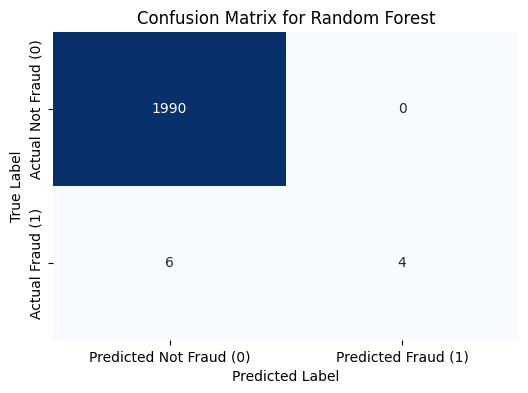


ROC AUC Score: 0.9983

Visualizing ROC Curve:


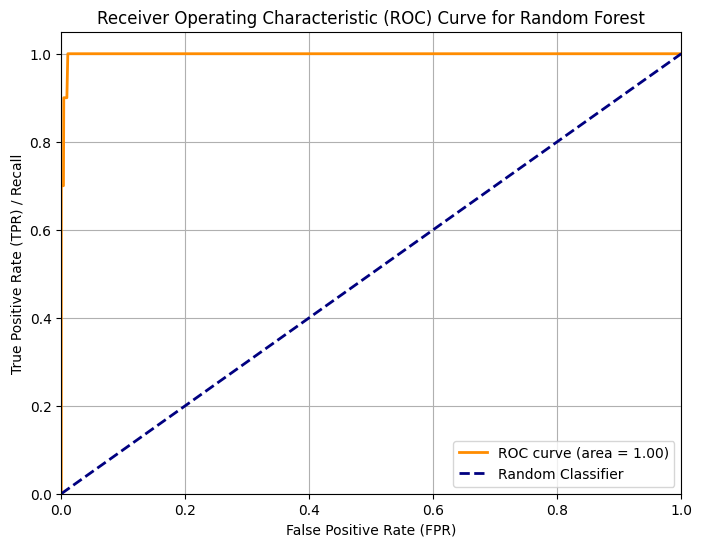


Precision (Fraud - Class 1): 1.0000
Recall (Fraud - Class 1): 0.4000
F1-Score (Fraud - Class 1): 0.5714


In [54]:
print("\n--- Model Evaluation on Test Set ---")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Not Fraud (0)', 'Predicted Fraud (1)'],
            yticklabels=['Actual Not Fraud (0)', 'Actual Fraud (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for {selected_model_name}')
plt.show()

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# ROC Curve Plot
print("\nVisualizing ROC Curve:")
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title(f'Receiver Operating Characteristic (ROC) Curve for {selected_model_name}')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Precision-Recall-Fscore Support
precision_fraud, recall_fraud, f1_fraud, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)
print(f"\nPrecision (Fraud - Class 1): {precision_fraud:.4f}")
print(f"Recall (Fraud - Class 1): {recall_fraud:.4f}")
print(f"F1-Score (Fraud - Class 1): {f1_fraud:.4f}")


## Understanding Fraud Detection Metrics


---


**Recall** (Catching Fraudsters):

This is about how many actual fraudsters your security guard successfully catches. A high Recall means they're not letting many bad guys slip by. You want this really high because you don't want to miss actual fraud and lose money.


---


**Precision** (Not Blaming Innocents):

This tells you how often your security guard is right when they yell 'Fraud!' A high Precision means they're usually spot on and not stopping a bunch of innocent customers by mistake. You want this high so you don't annoy your good customers with false alarms.



---


**F1-Score** (A Balanced Score):

This is like a combined score for both 'catching fraudsters' (Recall) and 'being right' (Precision). It's handy because in fraud, there are way more honest people than fraudsters, so you need a balance. A good F1-Score means your guard is pretty good at both jobs.


---


**ROC AUC Score** (Overall Goodness):

This is a general score that tells you how well your guard can tell the difference between a real customer and a fraudster, overall. The higher this score, the better they are at separating the two groups.
